# Quantifying Catchment Areas

Quantifying catchment areas for forest recreation based on different modes of travel (e.g., public transportation vs. private autos) is an essential part of understanding accessibility. The catchment area refers to the geographic area from which people can reach a particular site, such as a public forest, within a given travel time. Below is a detailed step-by-step workflow for quantifying and mapping these catchment areas using both public transportation and private autos.

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, LineString, box
import osmnx as ox
import networkx as nx

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='osmnx')

1. Prepare Input Data

Ensure that each forest has an assigned "attractiveness" score based on Old Growth status and public access.


In [8]:
file_path = '/Users/mihiarc/Work/data/'

# load national forest boundaries
forest_boundary = gpd.read_file(file_path + 'spatial-boundaries/nfs-layers/national-forests/S_USA.AdministrativeForest.shp')
forest_boundary_region_8 = forest_boundary[forest_boundary['REGION'] == '08']
# drop El Yunque National Forest
forest_boundary_region_8 = forest_boundary_region_8[forest_boundary_region_8['FORESTNAME'] != 'El Yunque National Forest']
# Load the forest plot data
forest_df = pd.read_csv(file_path + 'MOG_FIA-selected/FIA_2023_PLOT_US_MOG.csv')

# old growth only
# Filter data with specific criteria
forest_df = forest_df[
    (forest_df['LOCATION_NM'].isin(['Alabama', 'North Carolina', 'South Carolina',
                                    'Texas', 'Florida', 'Tennessee', 'Virginia',
                                    'Kentucky', 'Georgia', 'Mississippi',
                                    'Louisiana', 'Arkansas', 'Oklahoma'])) &
    (forest_df['MOG_LABEL'] == 'Old growth') &
    (forest_df['OWNGRPCD'] == 10)
]

# Create a GeoDataFrame with geometry from latitude and longitude
forest_gdf = gpd.GeoDataFrame(
    forest_df,
    geometry=gpd.points_from_xy(forest_df['LON'], forest_df['LAT']),
    crs='EPSG:4326'
)

# select only the national forests that contain points in forest_gdf
forest_boundary_mog = forest_boundary[forest_boundary.intersects(forest_gdf.unary_union)]

DriverError: /Users/mihiarc/Work/data/spatial-boundaries/nfs-layers/national-forests/S_USA.AdministrativeForest.shp: No such file or directory

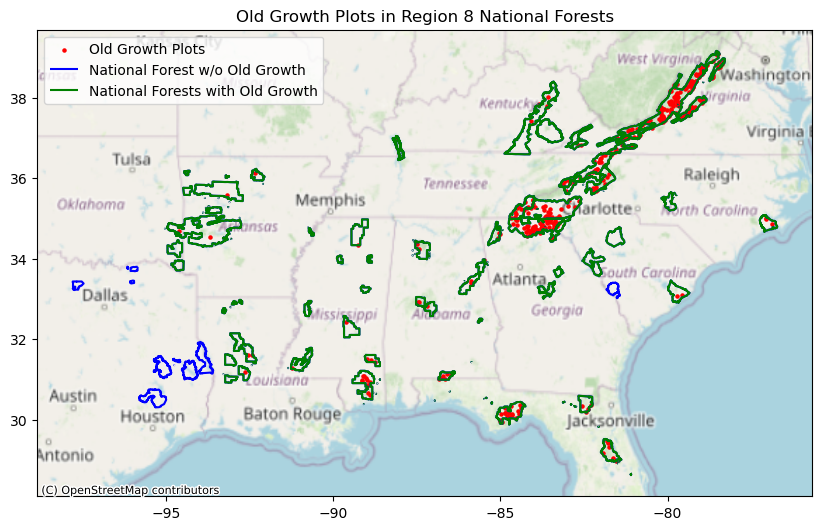

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
forest_gdf.plot(ax=ax, color='red', markersize=5)
forest_boundary_region_8.boundary.plot(ax=ax, color='blue')
forest_boundary_mog.boundary.plot(ax=ax, color='green')
# Add basemap
ctx.add_basemap(ax, crs=forest_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
# add legend
plt.legend(['Old Growth Plots', 'National Forest w/o Old Growth', 'National Forests with Old Growth'])
plt.title('Old Growth Plots in Region 8 National Forests')
plt.show()

2. Set Travel Time Thresholds
   
Define reasonable travel time thresholds for both modes:

* Private Autos: Set a time threshold (e.g., 30 or 45 minutes). Include driving and parking times.

3. Create Travel Time Areas (Service Areas)

* For Private Autos: Use road network data to create isochrones  or service areas for each forest. These are polygons that represent all the locations reachable within a certain travel time (e.g., 30 minutes) from the forest’s entry point. 

In [ ]:
import geopandas as gpd
import contextily as ctx
import pandas as pd
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
import matplotlib.pyplot as plt

def create_isochrones_for_forest(forest_gdf, time_limits):
    # Reproject to WGS84
    forest_gdf = forest_gdf.to_crs(epsg=4326)
    
    # Build the convex hull and buffer
    convex_hull = forest_gdf.unary_union.convex_hull
    buffered_hull = convex_hull.buffer(0.5)  # Buffer by degrees
    west, south, east, north = buffered_hull.bounds
    
    # Download the road network within the bounding box
    G = ox.graph_from_bbox(
        north=north,
        south=south,
        east=east,
        west=west,
        network_type='drive'
    )
    
    # Add edge speeds and travel times
    ox.speed.add_edge_speeds(G)
    ox.speed.add_edge_travel_times(G)
    
    # Find the centroid of the national forest
    forest_centroid = forest_gdf.unary_union.representative_point()
    # Get the nearest node to the representative point
    centroid_node = ox.nearest_nodes(G, X=forest_centroid.x, Y=forest_centroid.y)
    
    isochrone_polygons = []
    
    # For each travel time limit
    for time_limit in time_limits:
        # Convert time limit to seconds
        time_limit_sec = time_limit * 60
        
        # Use Dijkstra's algorithm to find reachable nodes within time limit
        subgraph = nx.ego_graph(G, centroid_node, radius=time_limit_sec, distance='travel_time')
        
        # Get the nodes and their geometries
        node_points = []
        for node in subgraph.nodes:
            x = G.nodes[node]['x']
            y = G.nodes[node]['y']
            node_points.append(Point(x, y))
        if not node_points:
            continue
        nodes_gdf = gpd.GeoDataFrame(geometry=node_points, crs='EPSG:4326')
        
        # Create a convex hull of the nodes to form the isochrone polygon
        isochrone_polygon = nodes_gdf.unary_union.convex_hull
        
        # Store the isochrone polygon with the travel time
        isochrone_polygons.append({
            'geometry': isochrone_polygon,
            'travel_time': time_limit
        })
    
    # Create a GeoDataFrame of isochrone polygons
    isochrone_gdf = gpd.GeoDataFrame(isochrone_polygons, crs='EPSG:4326')
    
    return isochrone_gdf


/var/folders/c9/dwfk30c575n0dw3tkq6prd940000gn/T/ipykernel_49350/1004007160.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  forest_test.centroid.plot(ax=ax, color='red')


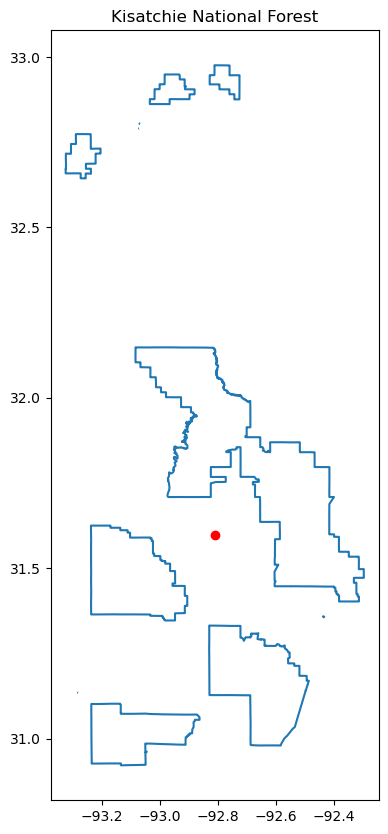

In [ ]:
# Example usage:

# select a forest to test the function
forest_test = forest_boundary_region_8[forest_boundary_region_8['FORESTNAME'] == 'Kisatchie National Forest']

# plot the forest boundary
fig, ax = plt.subplots(figsize=(10, 10))
forest_test.boundary.plot(ax=ax)
forest_test.centroid.plot(ax=ax, color='red')
plt.title('Kisatchie National Forest')
plt.show()

In [10]:
# Load the GeoJSON file
geojson_path = '/Users/mihiarc/Work/repos/nfs-econ-research/hiking-trails/Badin Lake Trail.js'
trails_gdf = gpd.read_file(geojson_path)


In [11]:
trails_gdf

name                                               desc  \
0  Trail Planner Map  Generated by AllTrails https://www.alltrails.com/   

                                            geometry  
0  MULTILINESTRING Z ((-80.07981 35.45429 169.000...

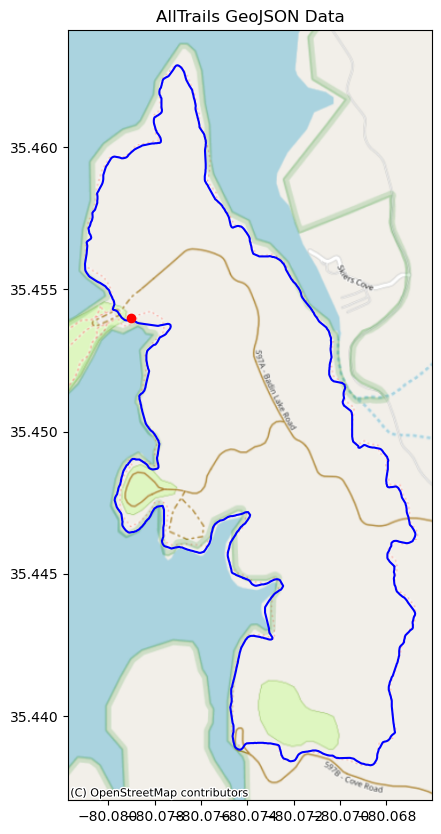

In [12]:

# Plot the GeoDataFrame with a basemap
fig, ax = plt.subplots(figsize=(10, 10))
trails_gdf.plot(ax=ax, color='blue', markersize=5)
ctx.add_basemap(ax, crs=trails_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
# add the trail head at 35.454, -80.079
plt.plot(-80.079, 35.454, 'ro')
plt.title('Badin Lake Trail')
plt.title('AllTrails GeoJSON Data')
plt.show()

/opt/anaconda3/envs/geo/lib/python3.9/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(
/var/folders/c9/dwfk30c575n0dw3tkq6prd940000gn/T/ipykernel_53545/2005917109.py:15: FutureWarning: The `add_edge_speeds` function has moved to the `routing` module. Calling `speed.add_edge_speeds` is deprecated and will be removed in the v2.0.0 release. Call it via `routing.add_edge_speeds` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.speed.add_edge_speeds(G)
/var/folders/c9/dwfk30c575n0dw3tkq6prd940000gn/T/ipykernel_53545/2005917109.py:16: FutureWarning: The `add_edge_travel_times` function has moved to the `routing` module. Calling `speed.add_edge_travel_times` is deprecated and will be removed in the v2.0.0 release. Call it via `routing.add_edge_travel_times` instead. See the OSMnx v2 migration guide: https://github.com

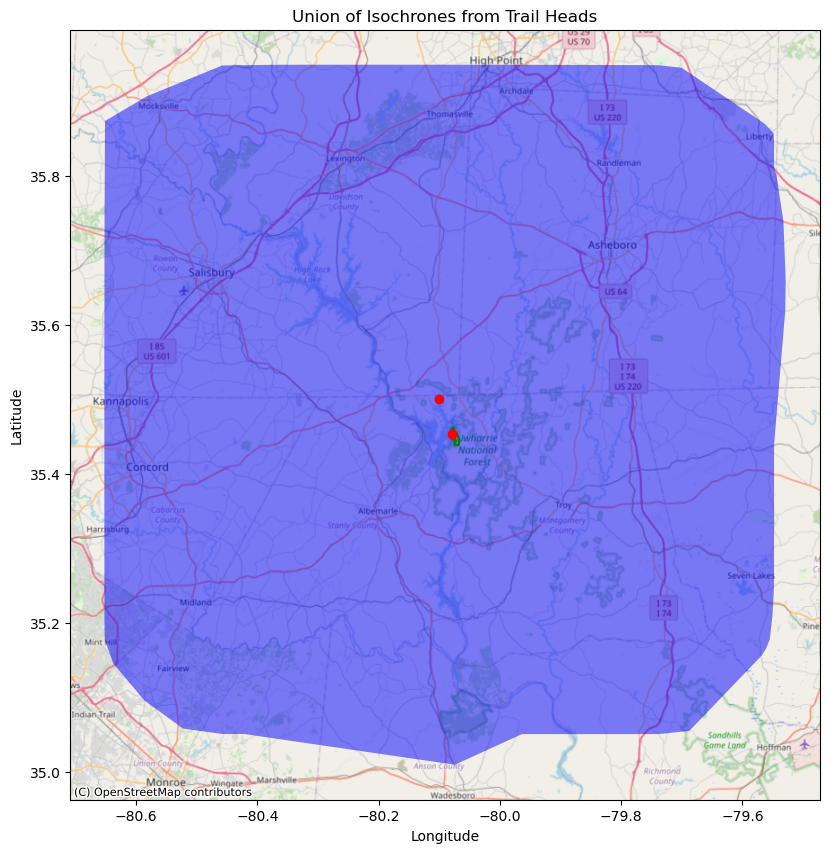

In [13]:
# Define the trail head coordinates
trail_head_coords_list = [(35.454, -80.079), (35.500, -80.100)]  # Add more coordinates as needed

# Define the travel time limit in minutes
travel_time_limit = 60

# Initialize an empty list to store isochrone polygons
isochrone_polygons = []

for trail_head_coords in trail_head_coords_list:
    # Download the road network within a bounding box around the trail head
    G = ox.graph_from_point(trail_head_coords, dist=50000, network_type='drive')

    # Add edge speeds and travel times
    ox.speed.add_edge_speeds(G)
    ox.speed.add_edge_travel_times(G)

    # Get the nearest node to the trail head
    trail_head_node = ox.nearest_nodes(G, X=trail_head_coords[1], Y=trail_head_coords[0])

    # Use Dijkstra's algorithm to find reachable nodes within the travel time limit
    travel_time_limit_sec = travel_time_limit * 60  # Convert minutes to seconds
    subgraph = nx.ego_graph(G, trail_head_node, radius=travel_time_limit_sec, distance='travel_time')

    # Get the nodes and their geometries
    node_points = []
    for node in subgraph.nodes:
        x = G.nodes[node]['x']
        y = G.nodes[node]['y']
        node_points.append(Point(x, y))

    # Create a GeoDataFrame of the nodes
    nodes_gdf = gpd.GeoDataFrame(geometry=node_points, crs='EPSG:4326')

    # Create a convex hull of the nodes to form the isochrone polygon
    isochrone_polygon = nodes_gdf.unary_union.convex_hull
    isochrone_polygons.append(isochrone_polygon)

# Create a GeoDataFrame for the union of isochrone polygons
union_isochrone_polygon = gpd.GeoSeries(isochrone_polygons).unary_union
isochrone_gdf = gpd.GeoDataFrame([{'geometry': union_isochrone_polygon, 'travel_time': travel_time_limit}], crs='EPSG:4326')

# Plot the isochrone
fig, ax = plt.subplots(figsize=(10, 10))
isochrone_gdf.plot(ax=ax, color='blue', alpha=0.5)
trails_gdf.plot(ax=ax, color='green')
ctx.add_basemap(ax, crs=isochrone_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
for coords in trail_head_coords_list:
    plt.plot(coords[1], coords[0], 'ro')  # Plot the trail heads
plt.title('Union of Isochrones from Trail Heads')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

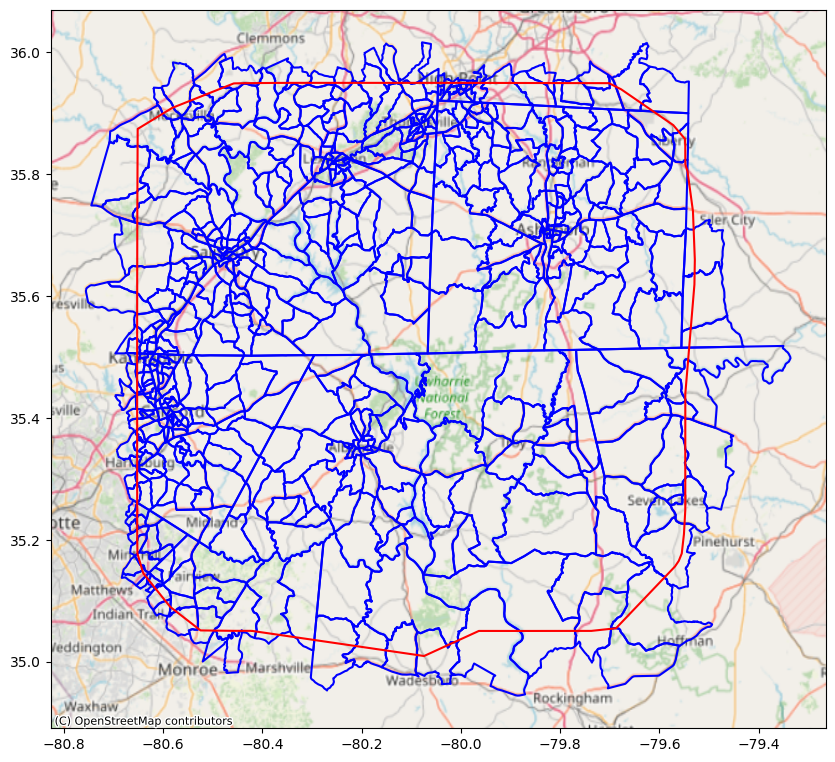

In [28]:
# load census block group boundaries
file_path = '/Users/mihiarc/Work/data/'
block_groups = gpd.read_file(file_path + 'spatial-boundaries/cb_2023_us_bg_500k/cb_2023_us_bg_500k.shp')

# Filter block groups to only include those within the isochrone polygon
block_groups_isochrone = block_groups[block_groups.intersects(isochrone_polygon)]

# Plot the block groups and isochrone
fig, ax = plt.subplots(figsize=(10, 10))
block_groups_isochrone.boundary.plot(ax=ax, color='blue')
isochrone_gdf.boundary.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs = block_groups_isochrone.crs, source = ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [29]:
# recreate the previous map using folium for an interactive map
import folium
from folium.plugins import MarkerCluster

# Create a folium map
m = folium.Map(location=[35.454, -80.079], zoom_start=10)

# Add the isochrone polygon to the map with 0.05 opacity and green fill color and red boundary
folium.GeoJson(
    isochrone_gdf,
    style_function=lambda x: {'fillColor': 'purple', 'color': 'red', 'fillOpacity': 0.4}
).add_to(m)

# Add the block groups to the map
folium.GeoJson(block_groups_isochrone).add_to(m)

# Add a marker for the trail head
folium.Marker([35.454, -80.079], popup='Trail Head').add_to(m)

# Display the map
m

In [23]:
import geopandas as gpd

# load census block group boundaries
file_path = '/Users/mihiarc/Work/data/'
nfs_trails = gpd.read_file(file_path + 'spatial-boundaries/nfs-layers/FS Hiking Trails/S_USA.TrailNFS_Publish.shp')


In [61]:
# select desired variables
nfs_trails_filtered = nfs_trails[['ADMIN_ORG', 'TRAIL_CN', 'TRAIL_NAME', 'TRAIL_NO', 'TRAIL_TYPE',
                         'BMP', 'EMP', 'SEGMENT_LE', 'GIS_MILES', 'SHAPE_LEN', 'geometry']].copy()

# create new columns for region, forest, and ranger district
# ADMIN_ORG format: '080101' where each code is two digits
nfs_trails_filtered['REGION'] = nfs_trails_filtered['ADMIN_ORG'].str[:2]
nfs_trails_filtered['FOREST'] = nfs_trails_filtered['ADMIN_ORG'].str[2:4]
nfs_trails_filtered['RANGER_DISTRICT'] = nfs_trails_filtered['ADMIN_ORG'].str[4:]

# filter trails in region 8
nfs_trails_region_8 = nfs_trails_filtered[nfs_trails_filtered['REGION'] == '08']

# filter for TERRA trail type
nfs_trails_region_8_terra = nfs_trails_region_8[nfs_trails_region_8['TRAIL_TYPE'] == 'TERRA']

# keep only trails with GIS_MILES <= 5
nfs_trails_region_8_terra_short = nfs_trails_region_8_terra[nfs_trails_region_8_terra['GIS_MILES'] <= 5]



In [63]:
# Group by 'TRAIL_NO' and get the index of the minimum 'GIS_MILES' for each group
min_gis_miles_idx = nfs_trails_region_8_terra_short.groupby('TRAIL_NO')['GIS_MILES'].idxmin()

# Use the indices to filter
nfs_trails_region_8_terra_min_gis_miles = nfs_trails_region_8_terra_short.loc[min_gis_miles_idx]


In [64]:
# repeat filtering using 'TRAIL_NAME' 
# Group by 'TRAIL_NAME' and get the index of the minimum 'GIS_MILES' for each group
min_gis_miles_idx = nfs_trails_region_8_terra_short.groupby('TRAIL_NAME')['GIS_MILES'].idxmin()

# Use the indices to filter
nfs_trails_region_8_terra_min_gis_miles_name = nfs_trails_region_8_terra_short.loc[min_gis_miles_idx]

In [65]:
# drop if missing geometry
nfs_trails_region_8_terra_min_gis_miles_name = nfs_trails_region_8_terra_min_gis_miles_name.dropna(subset=['geometry'])

In [66]:
# drop rows with multilinestring geometries
nfs_trails_region_8_terra_min_gis_miles_name = nfs_trails_region_8_terra_min_gis_miles_name[
    nfs_trails_region_8_terra_min_gis_miles_name['geometry'].apply(lambda x: x.geom_type) == 'LineString'
]

In [67]:
# Function to extract the starting point of a trail
def get_starting_point(geometry):
    if geometry.geom_type == 'LineString':
        return geometry.coords[0]
    else:
        return None

# Apply the function to create a new column with the starting point
nfs_trails_region_8_terra_min_gis_miles_name['starting_point'] = nfs_trails_region_8_terra_min_gis_miles_name['geometry'].apply(get_starting_point)

# Display the DataFrame with the new column
nfs_trails_region_8_terra_min_gis_miles_name[['TRAIL_NAME', 'starting_point']]

TRAIL_NAME                            starting_point
19612                 01  (-84.40813210800002, 30.402850032000003)
3917          0220N-0221  (-81.85236175199998, 29.368262316000028)
52825       0220N-0221-A   (-81.83321466899997, 29.36135526700002)
59113          0221-0222  (-81.87438282400001, 29.414029889999995)
4169         0221-0222-A  (-81.88399345800002, 29.407318997000004)
...                  ...                                       ...
65844       YELLOW PATCH   (-83.47942076999999, 35.04220114899999)
8352   YELLOW STAND LEAD   (-84.54303273900001, 35.04688823499998)
6820         YOTEE'S RUN   (-83.77919247300002, 35.00267270500001)
27186      ZEESTER TRAIL   (-93.50627970300002, 35.83963706200001)
5304      ZILPO MOUNTAIN  (-83.48776741699999, 38.070211701999995)

[2613 rows x 2 columns]

In [68]:
# make a copy called 'trail_starts' and convert 'starting_point' to a Point object
trail_starts = nfs_trails_region_8_terra_min_gis_miles_name.copy()

In [69]:
# use folium to plot the trail starting points
import folium
from folium.plugins import MarkerCluster

# Create a folium map centered on Region 8
m = folium.Map(location=[34.5, -84], zoom_start=5)

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(m)

# Add markers for the trail starting points
for idx, row in trail_starts.iterrows():
    coords = row['starting_point']
    if coords is not None:
        folium.Marker(location=[coords[1], coords[0]], popup=row['TRAIL_NAME']).add_to(marker_cluster)

# Display the map
m

In [70]:
# Save the folium map to an HTML file
m.save('region8_trail_map.html')

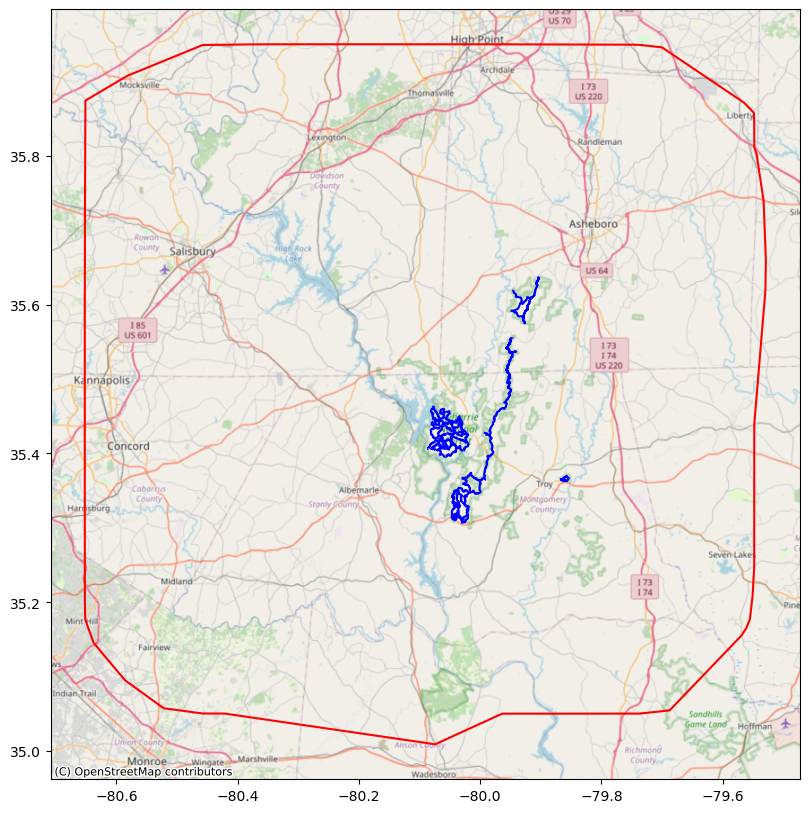

In [14]:
import contextily
import matplotlib.pyplot as plt
# clip the trails to the isochrone polygon
nfs_trails_isochrone = gpd.clip(nfs_trails, isochrone_polygon)

# Plot the trails and isochrone
fig, ax = plt.subplots(figsize=(10, 10))
nfs_trails_isochrone.plot(ax=ax, color='blue')
isochrone_gdf.boundary.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs = nfs_trails_isochrone.crs, source = ctx.providers.OpenStreetMap.Mapnik)
plt.show()

4. Intersect Catchment Areas with Population Data

* Overlay the service area polygons (for both public transport and private autos) onto the urban population data.

* For each urban area (e.g., census block or neighborhood), identify which areas fall within the catchment of the forest for each travel mode.

* For each mode of travel, calculate the total population within the defined service area of the forest. This gives you the catchment population for each forest based on the mode of travel.

5. Compare Catchment Areas for Different Modes of Travel

* For each forest, compare the population that can access the forest via public transport versus private autos. 

* Map the catchment areas and highlight areas where access is more limited by one mode of travel compared to the other.

* Use heatmaps or color-coded maps to show catchment areas for both travel modes. For instance, areas where both public transport and private auto access are high could be shown in one color, while areas accessible only by private auto (or public transport) could be shown in a different color.

* Consider using a difference map to show areas where private autos have better access than public transport (or vice versa).

6. Quantify Accessibility Metrics

- Population Coverage: Calculate the total population served by each mode of travel within

- Access Equity: Calculate the percentage of the population that only has access via public transport, only via private auto, or both.
    
- Forest Catchment Index: Create an index that combines accessibility by both modes of transport. For example:

Accessibility Index=  (〖Catchment〗_public+〖Catchment〗_auto)/(Total Population in Urban Area)

This index would indicate how accessible the forest is overall from a given urban area.


7. Mapping the Results

* Catchment Area Maps: Create maps that clearly display the service areas for public transport and private auto access. These maps should:

    * Differentiate between travel modes (e.g., shading for public transport and different shading for private auto).

    * Show the overlap of these catchment areas, revealing areas where both modes provide access.

* Equity Analysis Maps: Create additional maps showing areas where public transport access is lacking, and only private auto access exists. This helps identify gaps in transportation infrastructure for equitable access to forest recreation.

* Travel Time Comparison: Use contour maps or gradients to display the travel time differences between the two modes of transport to each forest.


8. Refining and Presenting Results

* Scenario Testing: Run the analysis under different scenarios, such as:
    - Varying public transport schedules (e.g., peak vs. off-peak).
    - Different travel time thresholds.
* Reporting: Summarize the results with visuals, tables, and key statistics, such as:
    - The proportion of the urban population that can access the forest within 30 minutes by public transport vs. private auto.
    - Identification of underserved areas that lack sufficient access to forest recreation by any travel mode
